In [1]:
# Import Dependencies
import pandas as pd
import sqlite3
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import session
from sqlalchemy import create_engine, func
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
# Create connection with database file
dbfile = '../housedata.db'
con = sqlite3.connect(dbfile)

In [3]:
# Creating Cursor
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# Print table list
print(table_list)

[('zip_code_database',), ('kc_house_data',), ('joined_table',)]


In [4]:
# Read in SQL query
db_df = pd.read_sql_query('SELECT * FROM joined_table', con)

In [5]:
db_df.head(10)

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,98178,STANDARD,0.0,Seattle,Tukwila,"Bryn Mawr, Skyway",WA,King County,America/Los_Angeles,206253425.0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,98125,STANDARD,0.0,Seattle,,"Lake City, Northgate",WA,King County,America/Los_Angeles,206.0,...,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639
2,98028,STANDARD,0.0,Kenmore,Bothell,,WA,King County,America/Los_Angeles,425.0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,98136,STANDARD,0.0,Seattle,,Westwood,WA,King County,America/Los_Angeles,206.0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,98074,STANDARD,0.0,Sammamish,Redmond,,WA,King County,America/Los_Angeles,206425.0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,98053,STANDARD,0.0,Redmond,,,WA,King County,America/Los_Angeles,206425.0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,98003,STANDARD,0.0,Federal Way,Auburn,,WA,King County,America/Los_Angeles,253.0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,98198,STANDARD,0.0,Seattle,"Des Moines, Normandy Park, Seatac",Redondo Beach,WA,King County,America/Los_Angeles,206253.0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,98146,STANDARD,0.0,Seattle,Burien,"Shorewood, White Center",WA,King County,America/Los_Angeles,253206.0,...,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,98038,STANDARD,0.0,Maple Valley,,"Four Corners, Wilderness Village",WA,King County,America/Los_Angeles,425.0,...,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [6]:
# Check for columns
db_df.columns

Index(['zip', 'type', 'decommissioned', 'primary_city', 'acceptable_cities',
       'unacceptable_cities', 'state', 'county', 'timezone', 'area_codes',
       'world_region', 'country', 'latitude', 'longitude',
       'irs_estimated_population_2015', 'id', 'date', 'price', 'bedrooms',
       'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

In [7]:
# Check for datatpyes
db_df.dtypes

zip                               object
type                              object
decommissioned                    object
primary_city                      object
acceptable_cities                 object
unacceptable_cities               object
state                             object
county                            object
timezone                          object
area_codes                        object
world_region                      object
country                           object
latitude                          object
longitude                         object
irs_estimated_population_2015      int64
id                                object
date                              object
price                              int64
bedrooms                           int64
bathrooms                         object
sqft_living                       object
sqft_lot                           int64
floors                           float64
waterfront                        object
view            

In [8]:
# Drop unneccessary columns
db_df = db_df.drop(columns=(['type', 'decommissioned', 'acceptable_cities', 'unacceptable_cities', 'state', 'county', 'timezone', 'area_codes', 'world_region', 'country', 'latitude', 'longitude', 'irs_estimated_population_2015', 'id', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'zip']))

In [9]:
# Check for columns
db_df.columns

Index(['primary_city', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'yr_built', 'yr_renovated', 'zipcode'],
      dtype='object')

In [10]:
# Determine the number of unique values in each column.
db_list = db_df.dtypes.index.tolist()


# Check the number of unique values in each column
db_df[db_list].nunique()

primary_city      24
date             372
price           3610
bedrooms          13
bathrooms         30
sqft_living     1038
sqft_lot        9782
floors             6
waterfront         2
view               5
condition          5
grade             12
yr_built         116
yr_renovated      70
zipcode           70
dtype: int64

In [11]:
# Check for missing data
for column in db_df.columns:
    print(f"Column {column} has {db_df[column].isnull().sum()} null values")

Column primary_city has 0 null values
Column date has 0 null values
Column price has 0 null values
Column bedrooms has 0 null values
Column bathrooms has 0 null values
Column sqft_living has 0 null values
Column sqft_lot has 0 null values
Column floors has 0 null values
Column waterfront has 0 null values
Column view has 0 null values
Column condition has 0 null values
Column grade has 0 null values
Column yr_built has 0 null values
Column yr_renovated has 0 null values
Column zipcode has 0 null values


In [12]:
# Convert date to show only year
db_df['date'] = db_df['date'].str[:4]

In [13]:
db_df.head(10)

,primary_city,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode
0,Seattle,2014,221900,3,1,1180,5650,1.0,0,0,3,7,1955,0,98178
1,Seattle,2014,538000,3,2.25,2570,7242,2.0,0,0,3,7,1951,1991,98125
2,Kenmore,2015,180000,2,1,770,10000,1.0,0,0,3,6,1933,0,98028
3,Seattle,2014,604000,4,3,1960,5000,1.0,0,0,5,7,1965,0,98136
4,Sammamish,2015,510000,3,2,1680,8080,1.0,0,0,3,8,1987,0,98074
5,Redmond,2014,1230000,4,4.5,5420,101930,1.0,0,0,3,11,2001,0,98053
6,Federal Way,2014,257500,3,2.25,1715,6819,2.0,0,0,3,7,1995,0,98003
7,Seattle,2015,291850,3,1.5,1060,9711,1.0,0,0,3,7,1963,0,98198
8,Seattle,2015,229500,3,1,1780,7470,1.0,0,0,3,7,1960,0,98146
9,Maple Valley,2015,323000,3,2.5,1890,6560,2.0,0,0,3,7,2003,0,98038


In [14]:
#for c in db_df.columns:
    #db_df[c] = pd.to_numeric(db_df[c], errors='coerce')

In [15]:
# Convert columns with dates to integers
db_df['date'] = pd.to_numeric(db_df['date'])
db_df['yr_built'] = pd.to_numeric(db_df['yr_built'])
db_df['house_age'] = db_df['date'] - db_df['yr_built']
db_df.head(5)

,primary_city,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,house_age
0,Seattle,2014,221900,3,1,1180,5650,1.0,0,0,3,7,1955,0,98178,59
1,Seattle,2014,538000,3,2.25,2570,7242,2.0,0,0,3,7,1951,1991,98125,63
2,Kenmore,2015,180000,2,1,770,10000,1.0,0,0,3,6,1933,0,98028,82
3,Seattle,2014,604000,4,3,1960,5000,1.0,0,0,5,7,1965,0,98136,49
4,Sammamish,2015,510000,3,2,1680,8080,1.0,0,0,3,8,1987,0,98074,28


In [16]:
db_df.dtypes

primary_city     object
date              int64
price             int64
bedrooms          int64
bathrooms        object
sqft_living      object
sqft_lot          int64
floors          float64
waterfront       object
view             object
condition         int64
grade             int64
yr_built          int64
yr_renovated     object
zipcode          object
house_age         int64
dtype: object

In [17]:
# Custom encode for primary city
# Rank cities by average price
average_price = db_df.groupby("primary_city")["price"].mean().rank(axis=0, ascending=False)
# Convert to dataframe
average_price_df = average_price.to_frame(name="city_rank")

# Merge rank with housedata and drop primary city
db_df = db_df.merge(average_price_df,on = "primary_city", how="left").drop("primary_city",1)
db_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,house_age,city_rank
0,2014,221900,3,1,1180,5650,1.0,0,0,3,7,1955,0,98178,59,10.0
1,2014,538000,3,2.25,2570,7242,2.0,0,0,3,7,1951,1991,98125,63,10.0
2,2015,180000,2,1,770,10000,1.0,0,0,3,6,1933,0,98028,82,14.0
3,2014,604000,4,3,1960,5000,1.0,0,0,5,7,1965,0,98136,49,10.0
4,2015,510000,3,2,1680,8080,1.0,0,0,3,8,1987,0,98074,28,4.0


In [18]:
# Save DataFrame to csv
db_df.to_csv('merged_data.csv')

In [19]:
# Filter out outliers
db_df = db_df[db_df['price'] < 4000000]  
db_df.head(10)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,house_age,city_rank
0,2014,221900,3,1,1180,5650,1.0,0,0,3,7,1955,0,98178,59,10.0
1,2014,538000,3,2.25,2570,7242,2.0,0,0,3,7,1951,1991,98125,63,10.0
2,2015,180000,2,1,770,10000,1.0,0,0,3,6,1933,0,98028,82,14.0
3,2014,604000,4,3,1960,5000,1.0,0,0,5,7,1965,0,98136,49,10.0
4,2015,510000,3,2,1680,8080,1.0,0,0,3,8,1987,0,98074,28,4.0
5,2014,1230000,4,4.5,5420,101930,1.0,0,0,3,11,2001,0,98053,13,5.0
6,2014,257500,3,2.25,1715,6819,2.0,0,0,3,7,1995,0,98003,19,24.0
7,2015,291850,3,1.5,1060,9711,1.0,0,0,3,7,1963,0,98198,52,10.0
8,2015,229500,3,1,1780,7470,1.0,0,0,3,7,1960,0,98146,55,10.0
9,2015,323000,3,2.5,1890,6560,2.0,0,0,3,7,2003,0,98038,12,20.0


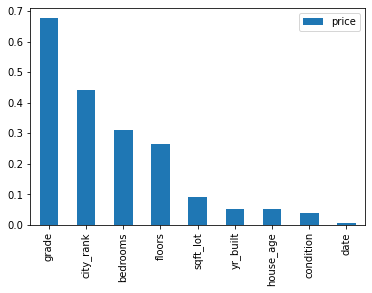

In [20]:
# Calculate Pearsons Correlation coefficient
corr_full = db_df.corr(method = "pearson")
corr = corr_full[["price"]].copy()
corr["price"] = abs(corr["price"])
corr = corr.drop(index="price")
corr = corr.sort_values(by=['price'],ascending=False)
corr.plot(kind ="bar",y="price")

In [21]:
# Select features that have correlation greater than or equal to 0.5
sel_feature_pearsons = corr[corr["price"]>0.05].index.values.tolist()
sel_feature_pearsons

['grade',
 'city_rank',
 'bedrooms',
 'floors',
 'sqft_lot',
 'yr_built',
 'house_age']

In [22]:
# Filter for selected features only
corr_test = corr_full.filter(sel_feature_pearsons, axis=1)
corr_test

,grade,city_rank,bedrooms,floors,sqft_lot,yr_built,house_age
date,-0.025264,0.030467,-0.010006,-0.018672,0.006048,0.007632,0.008231
price,0.677535,-0.443067,0.311391,0.263565,0.091194,0.052974,-0.052870
bedrooms,0.356237,-0.047698,1.000000,0.174516,0.031404,0.153553,-0.153711
sqft_lot,0.112316,0.061525,0.031404,-0.006139,1.000000,0.052376,-0.052280
floors,0.457652,-0.033688,0.174516,1.000000,-0.006139,0.489223,-0.489517
condition,-0.148123,-0.003600,0.028176,-0.266557,-0.009222,-0.364831,0.364120
grade,1.000000,-0.216679,0.356237,0.457652,0.112316,0.446167,-0.446566
yr_built,0.446167,0.111553,0.153553,0.489223,0.052376,1.000000,-0.999874
house_age,-0.446566,-0.111070,-0.153711,-0.489517,-0.052280,-0.999874,1.000000
city_rank,-0.216679,1.000000,-0.047698,-0.033688,0.061525,0.111553,-0.111070


In [23]:
# Create independant & dependant variables
X = db_df[sel_feature_pearsons]
y = db_df['price']

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

#Transforming y_train to log
y_train = np.log(y_train)

# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)
# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [24]:
# Create linear regression object
regr = LinearRegression()
# Train the model using the training sets
regr = regr.fit(X_train_scaled, y_train)
# Make predictions using the testing set
y_pred = regr.predict(X_test_scaled)
y_pred = np.exp(y_pred)

# The coefficients
print('Root Mean Squared Error:', metrics.mean_absolute_error(y_test, y_pred))
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Root Mean Squared Error: 121304.17881992986
Mean squared error: 43106144874.93
Coefficient of determination: 0.66


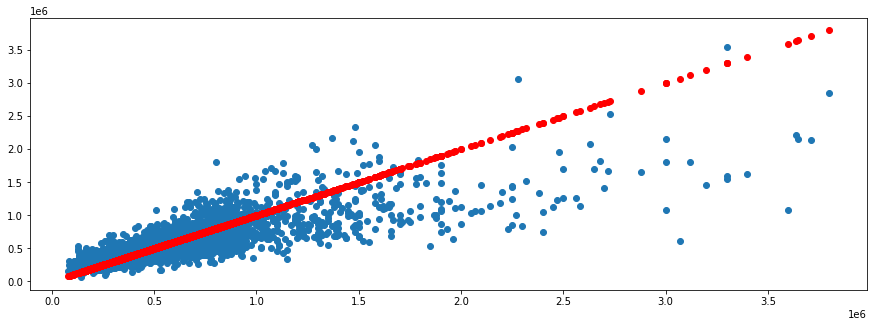

In [25]:
# Plot Linear Regression model
plt.figure(figsize=(15,5))
plt.scatter(y_test, y_pred)
plt.scatter(y_test,y_test,color="red")

In [26]:
# Create Random Forst Regressor object
rf_reg = RandomForestRegressor(random_state=0, n_estimators=500)
rf_reg = rf_reg.fit(X_train_scaled, y_train)
rf_pred_y = rf_reg.predict(X_test_scaled)
rf_pred_y = np.exp(rf_pred_y)

# The root mean squared error
print('Root Mean Squared Error:', metrics.mean_absolute_error(y_test, rf_pred_y))
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, rf_pred_y))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, rf_pred_y))

Root Mean Squared Error: 103597.5399015471
Mean squared error: 33086736363.89
Coefficient of determination: 0.74


In [27]:
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
rf_reg = rf_reg.fit(X_train_scaled, y_train)
rf_pred_y = rf_reg.predict(X_test_scaled)
rf_pred_y = np.exp(rf_pred_y)

# The root mean squared error
print('Root Mean Squared Error:', metrics.mean_absolute_error(y_test, rf_pred_y))
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, rf_pred_y))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, rf_pred_y))

Root Mean Squared Error: 103583.27040011436
Mean squared error: 33089784169.44
Coefficient of determination: 0.74


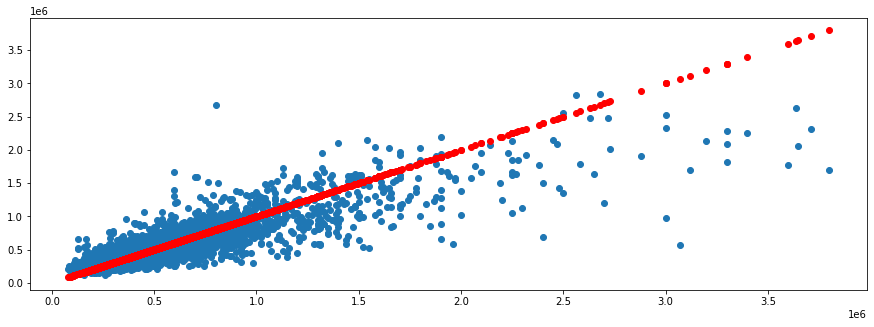

In [28]:
# Plot the Random Forest Regressor model
plt.figure(figsize=(15,5))
plt.scatter(y_test, rf_pred_y)
plt.scatter(y_test,y_test,color="red")